In [10]:
import pandas as pd
import requests
from matplotlib import pyplot as plt
import os
import shutil

with open('API_KEY.txt', 'r') as keyfile:
    api_key = keyfile.read()                                           #Your API key goes here

def compare(players, modes, drops):

    cwd = os.getcwd()                                               #Get current directory and create new one for results
    destination = os.path.join(cwd, '-'.join(players)) 
    if not os.path.exists(destination):
        os.makedirs(destination)
    else:
        shutil.rmtree(destination)           
        os.makedirs(destination)
    
    
    def getID(playername):                                          #Gets the player ID associated with each player name. Seems like this 2nd call to API could be avoided

        url = "https://api.pubg.com/shards/steam/players?filter[playerNames]="+playername          
        header = {
          "Authorization": "Bearer "+api_key,
          "Accept": "application/vnd.api+json"
        }

        IDdata = requests.get(url, headers=header).json()
        return (IDdata['data'][0]['id'])
    
    
    
    jsons=[]
    IDS = []
    for player in players:
        IDS.append(getID(player))
    
    
    
    for ID in IDS:                                                #Gets the lifetime history of each player ID
        url = "https://api.pubg.com/shards/steam/players/" + ID + "/seasons/lifetime"          
        header = {
          "Authorization": "Bearer "+api_key,
          "Accept": "application/vnd.api+json"
        }
        response = requests.get(url, headers=header).json()
        jsons.append(response)
   
    #Concatenate and tidy up the data
    all_data = pd.concat([pd.DataFrame(jsons[i]['data']['attributes']['gameModeStats']) for i in range(len(players))], axis=1, keys = players)
    all_data.to_excel('-'.join(players)+'.xls')      #save to excel file
    shutil.move('-'.join(players)+'.xls', destination)
    
    def generate_plots(mode, players, drops):                           #Generates the plots for each mode
        data = all_data.drop(drops)     
        data.fillna(0, inplace=True)

        fig = plt.figure(figsize=(40,35), dpi=100)
        fig.suptitle('PUBG 2018 - '+'-'.join(players)+'-'+mode, fontsize=40)  

        for i in range(len(data[data.columns[0]])):
            fig.add_subplot(4, 8, i+1, xmargin=0.5, ymargin=0.5)
            fig.subplots_adjust(wspace=0.5, hspace=0.5)
            data.iloc[i].xs(mode, level=1).plot(kind='bar', title=data.index[i])
            fig.savefig(destination+'\\'+mode)                         #Save figure to file
   
    for m in modes:                                                    #Generate one file per mode
        print('Comparing players in mode {}'.format(m))
        generate_plots(m,players,drop_graphs)
    
    
    print('\n ---')                                                    #Summary of K/D ratios as a check that everything worked
    print('K/D ratios  :')
    for p in players:
        for m in modes:
            kd = all_data[p][m].loc['kills'] / all_data[p][m].loc['losses'] 
            print ('{}\'s K/D ratio in {} is : {:.3f}'.format(p, m, kd))          
        

Comparing players in mode solo-fpp
Comparing players in mode duo-fpp
Comparing players in mode squad-fpp

 ---
K/D ratios  :
Marky_Boi's K/D ratio in solo-fpp is : 1.189
Marky_Boi's K/D ratio in duo-fpp is : 0.857
Marky_Boi's K/D ratio in squad-fpp is : 1.200
simonr0204's K/D ratio in solo-fpp is : 1.289
simonr0204's K/D ratio in duo-fpp is : 0.944
simonr0204's K/D ratio in squad-fpp is : 0.928
01zaporozhets's K/D ratio in solo-fpp is : 0.500
01zaporozhets's K/D ratio in duo-fpp is : 0.726
01zaporozhets's K/D ratio in squad-fpp is : 0.952


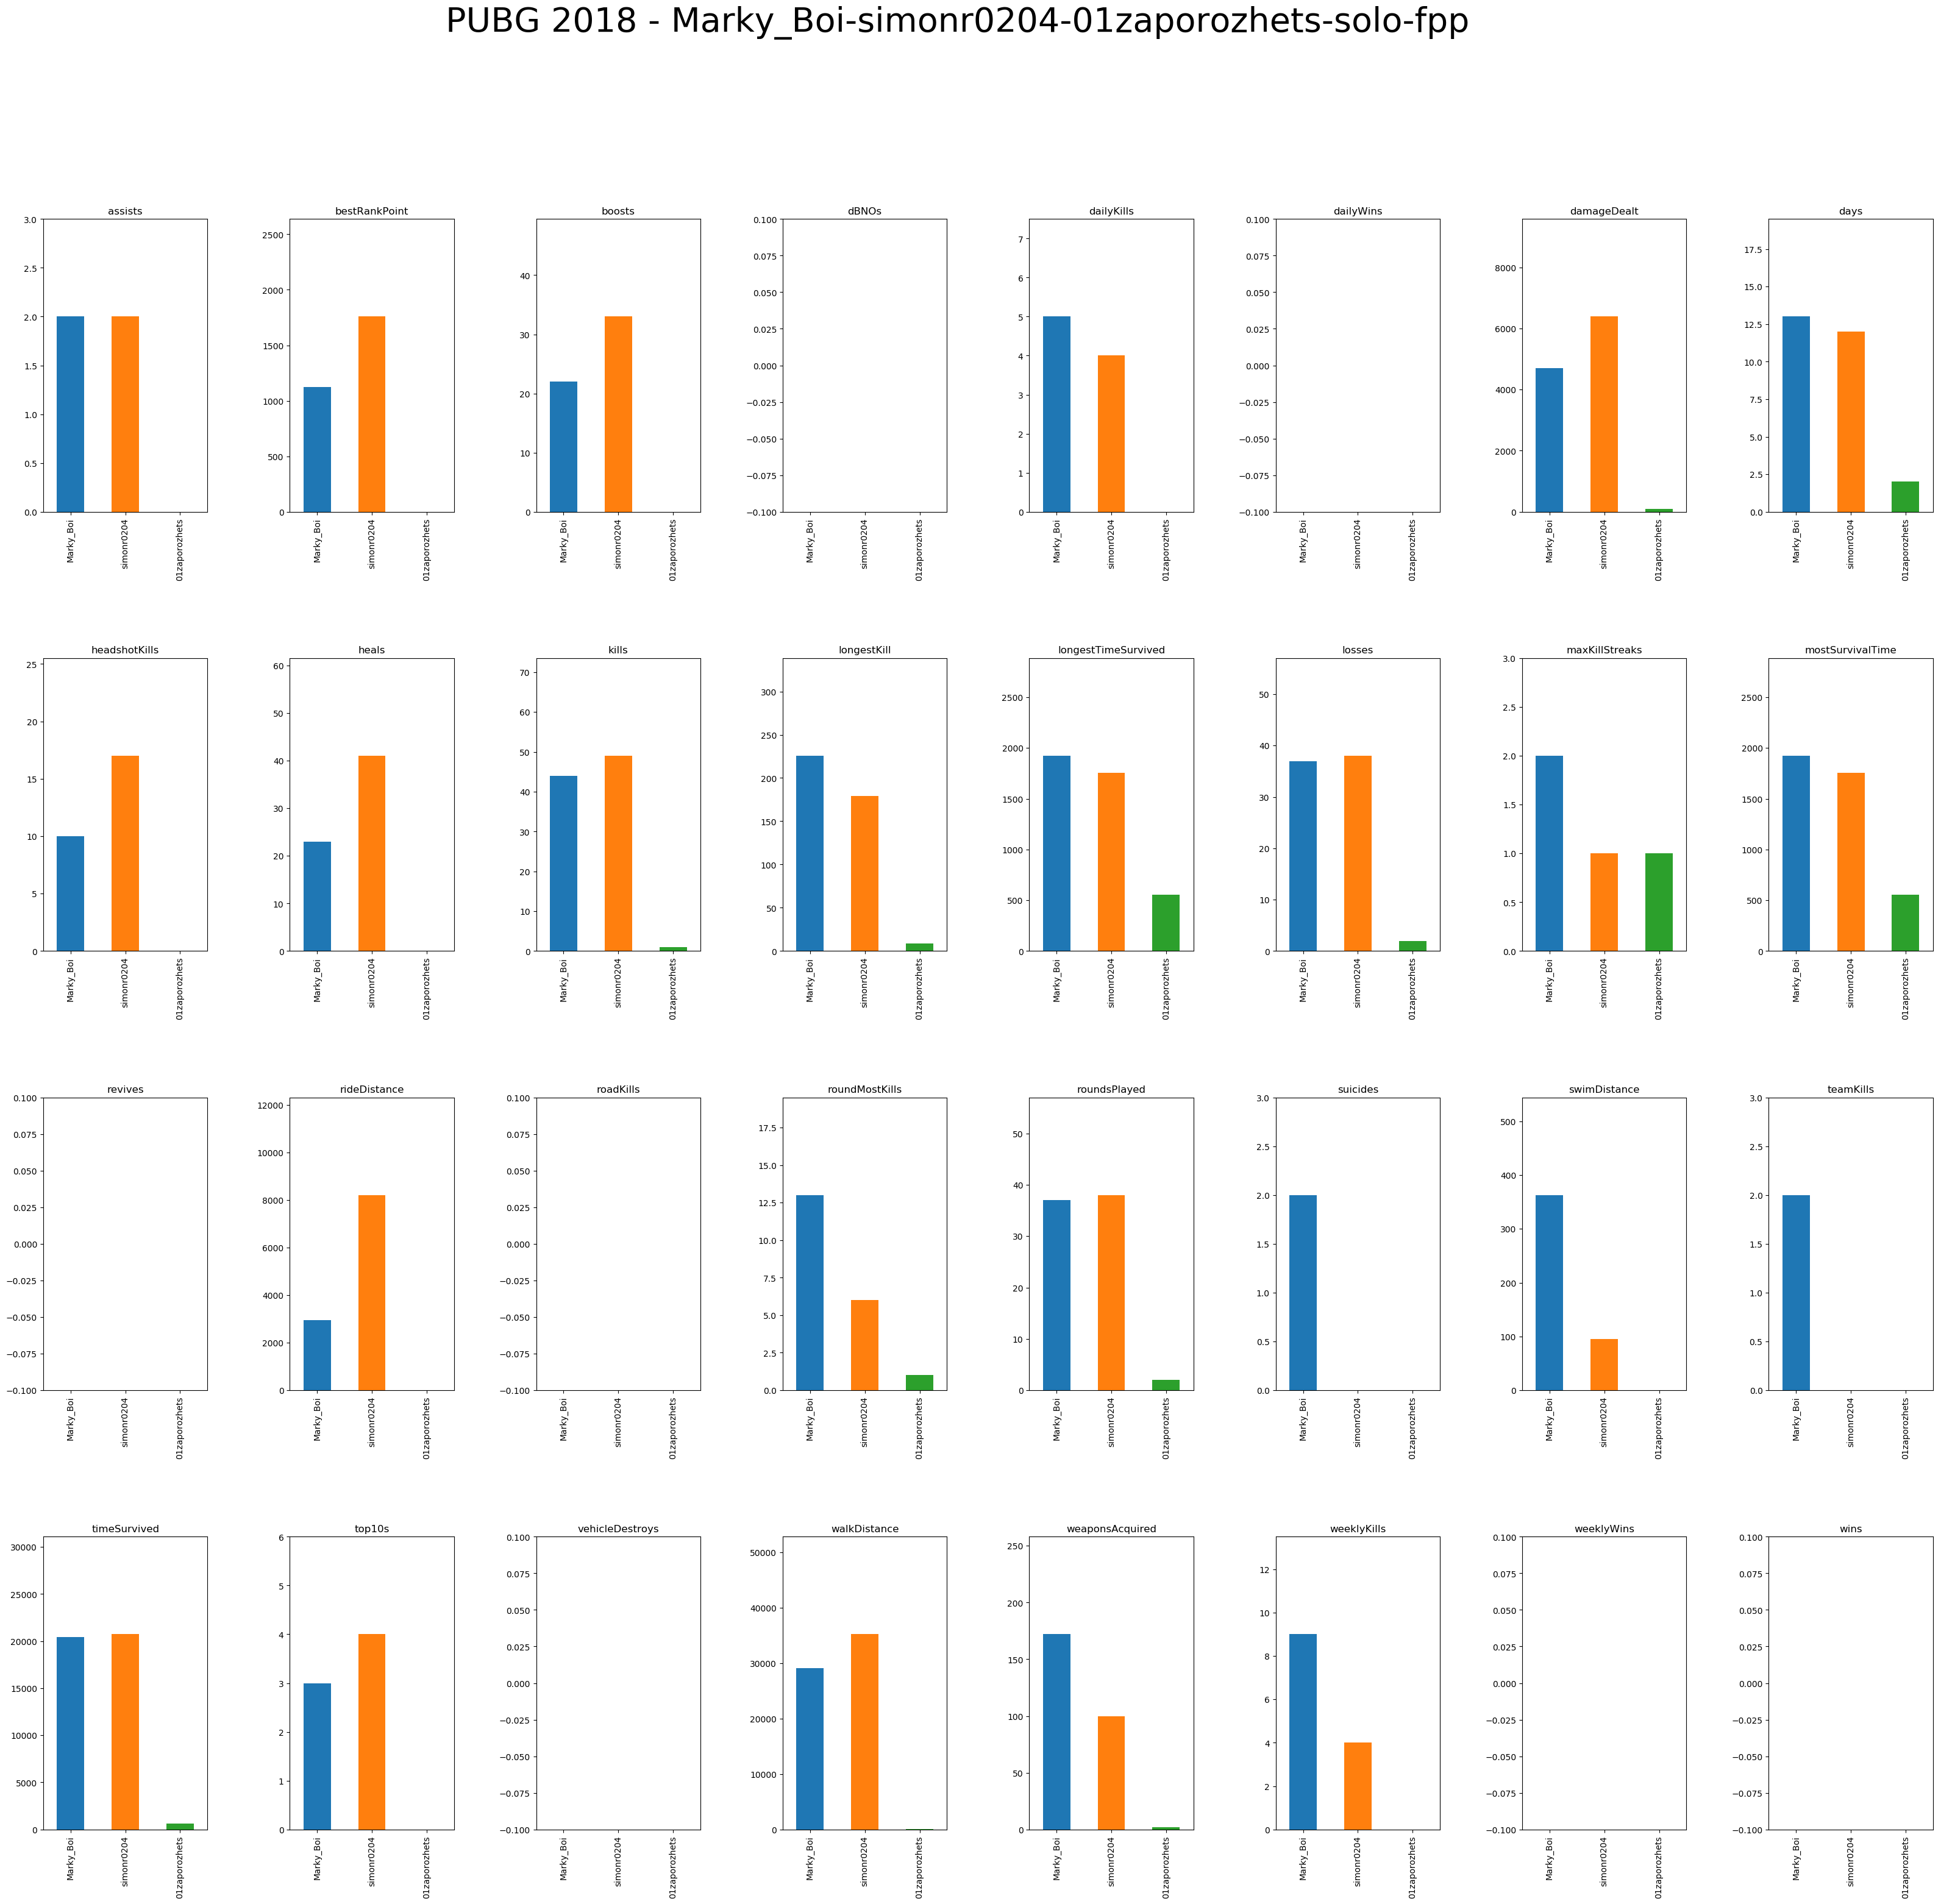

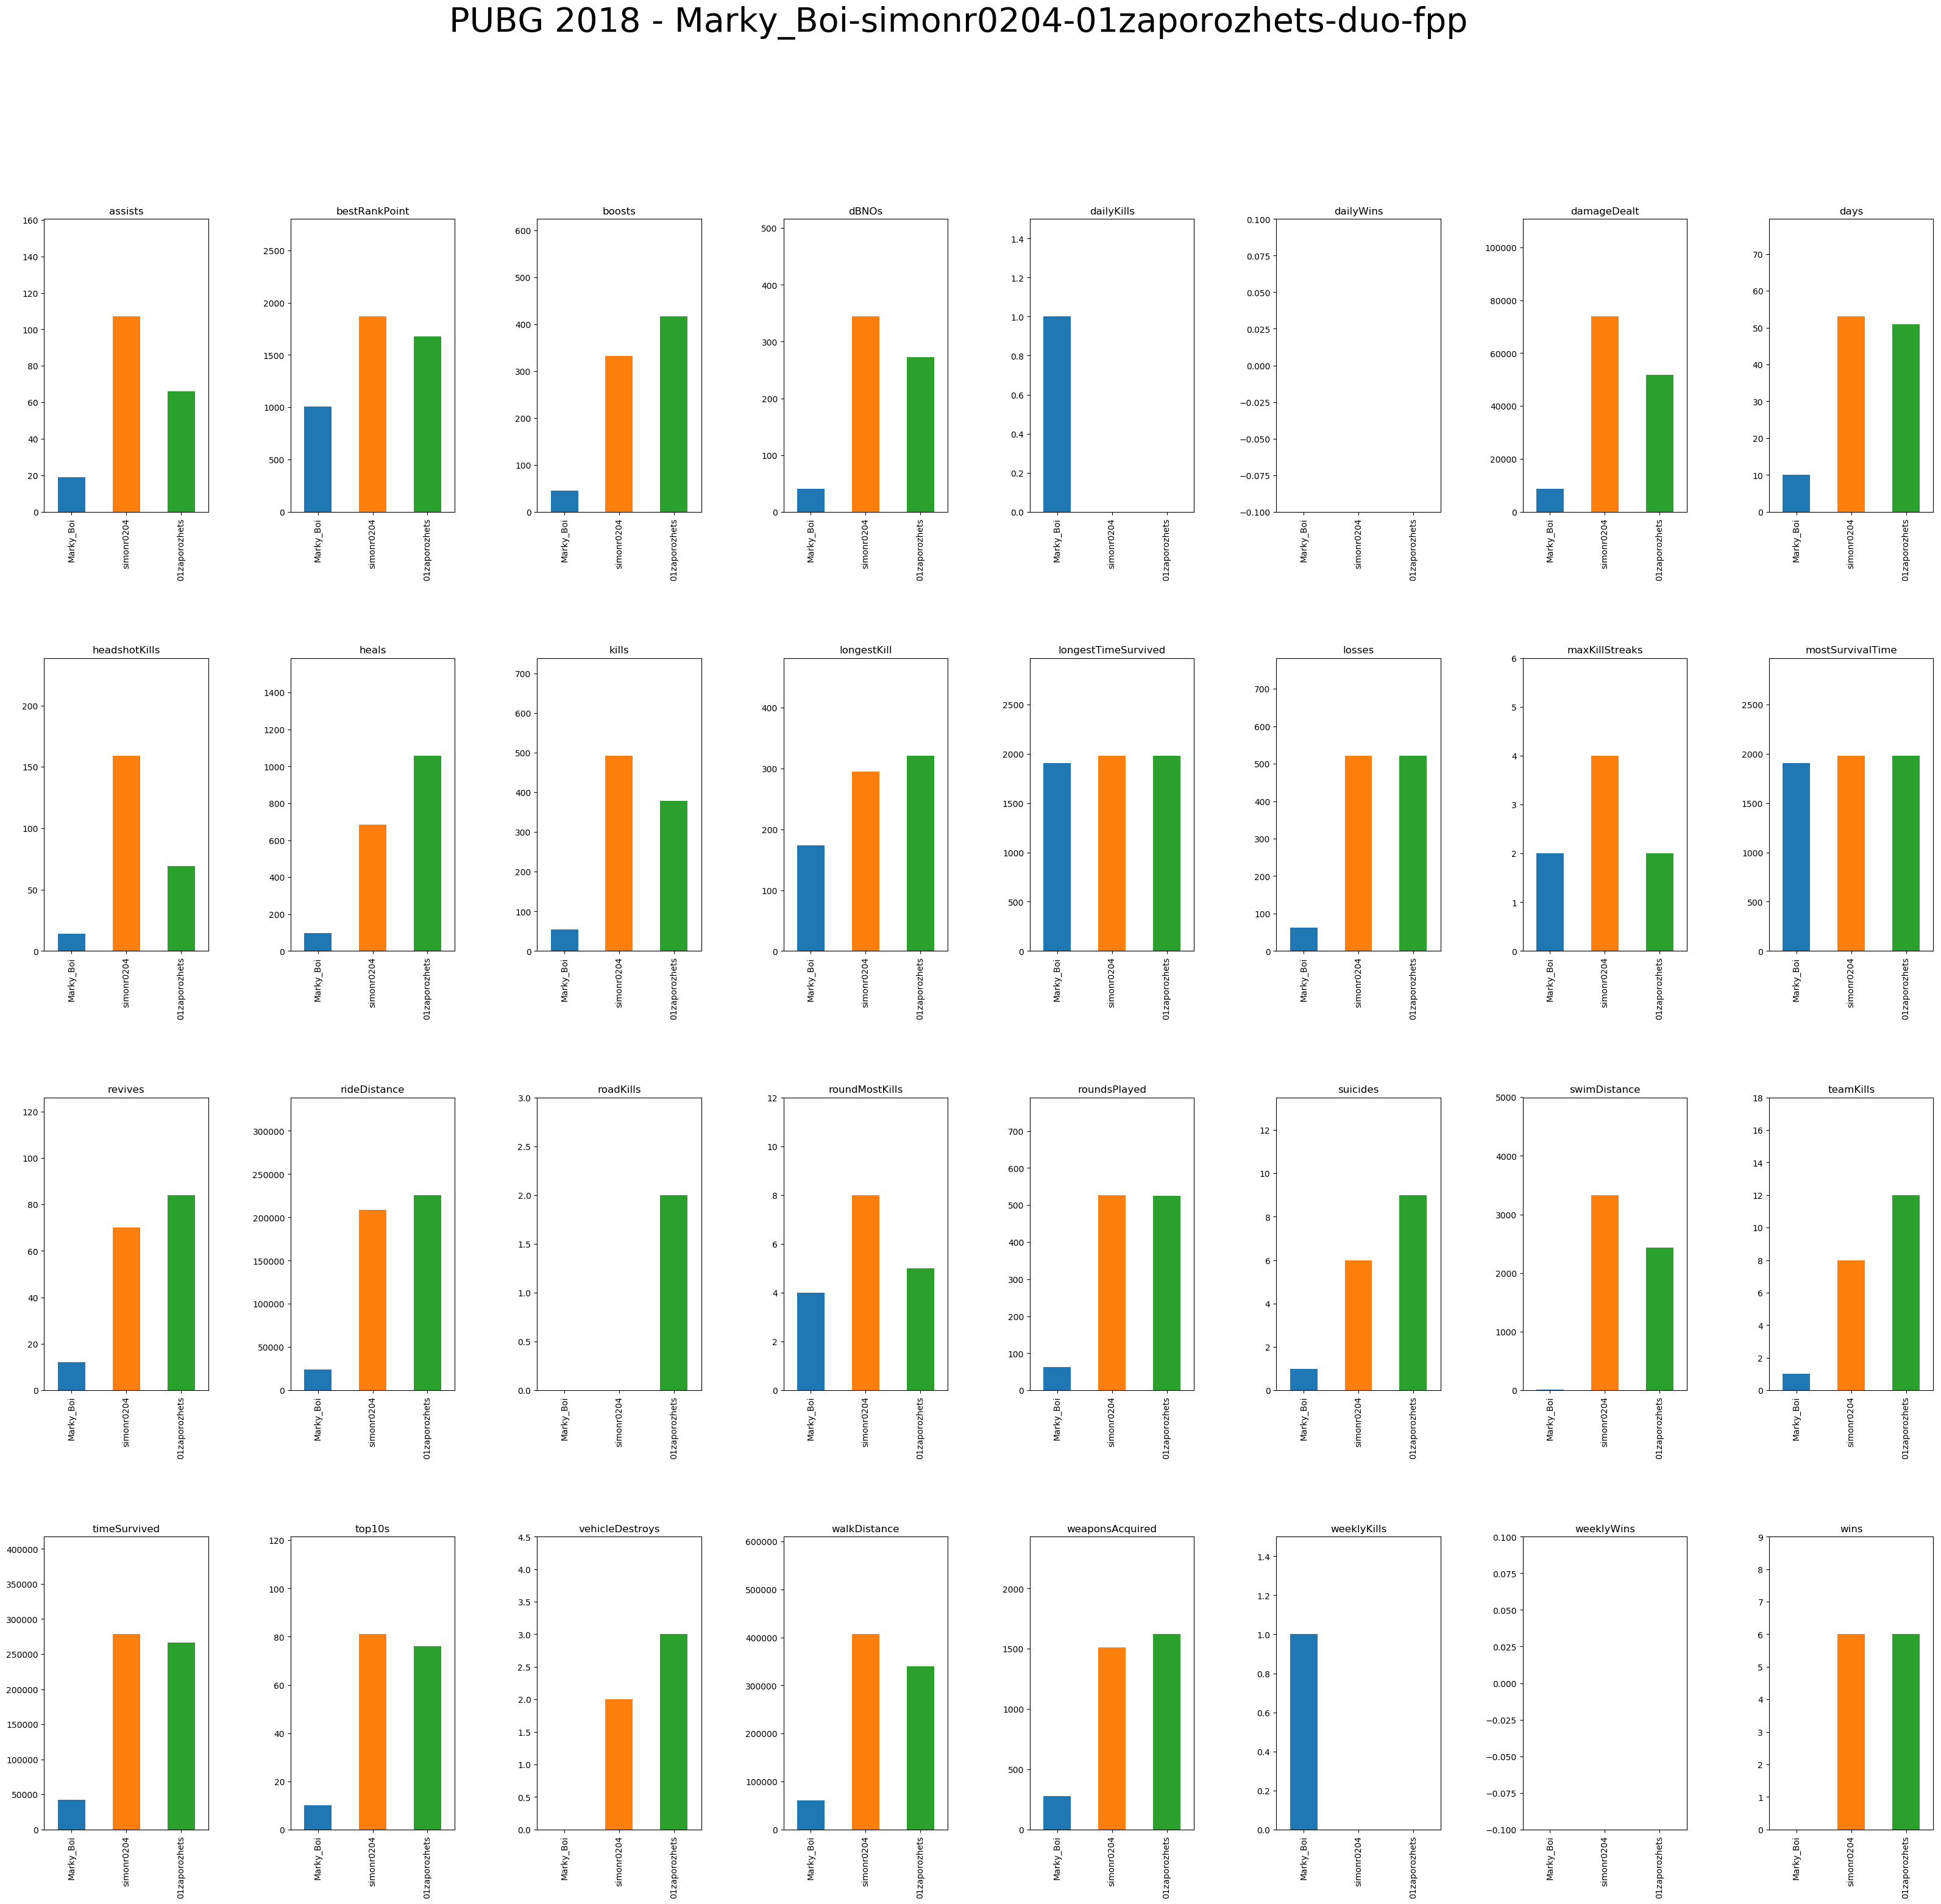

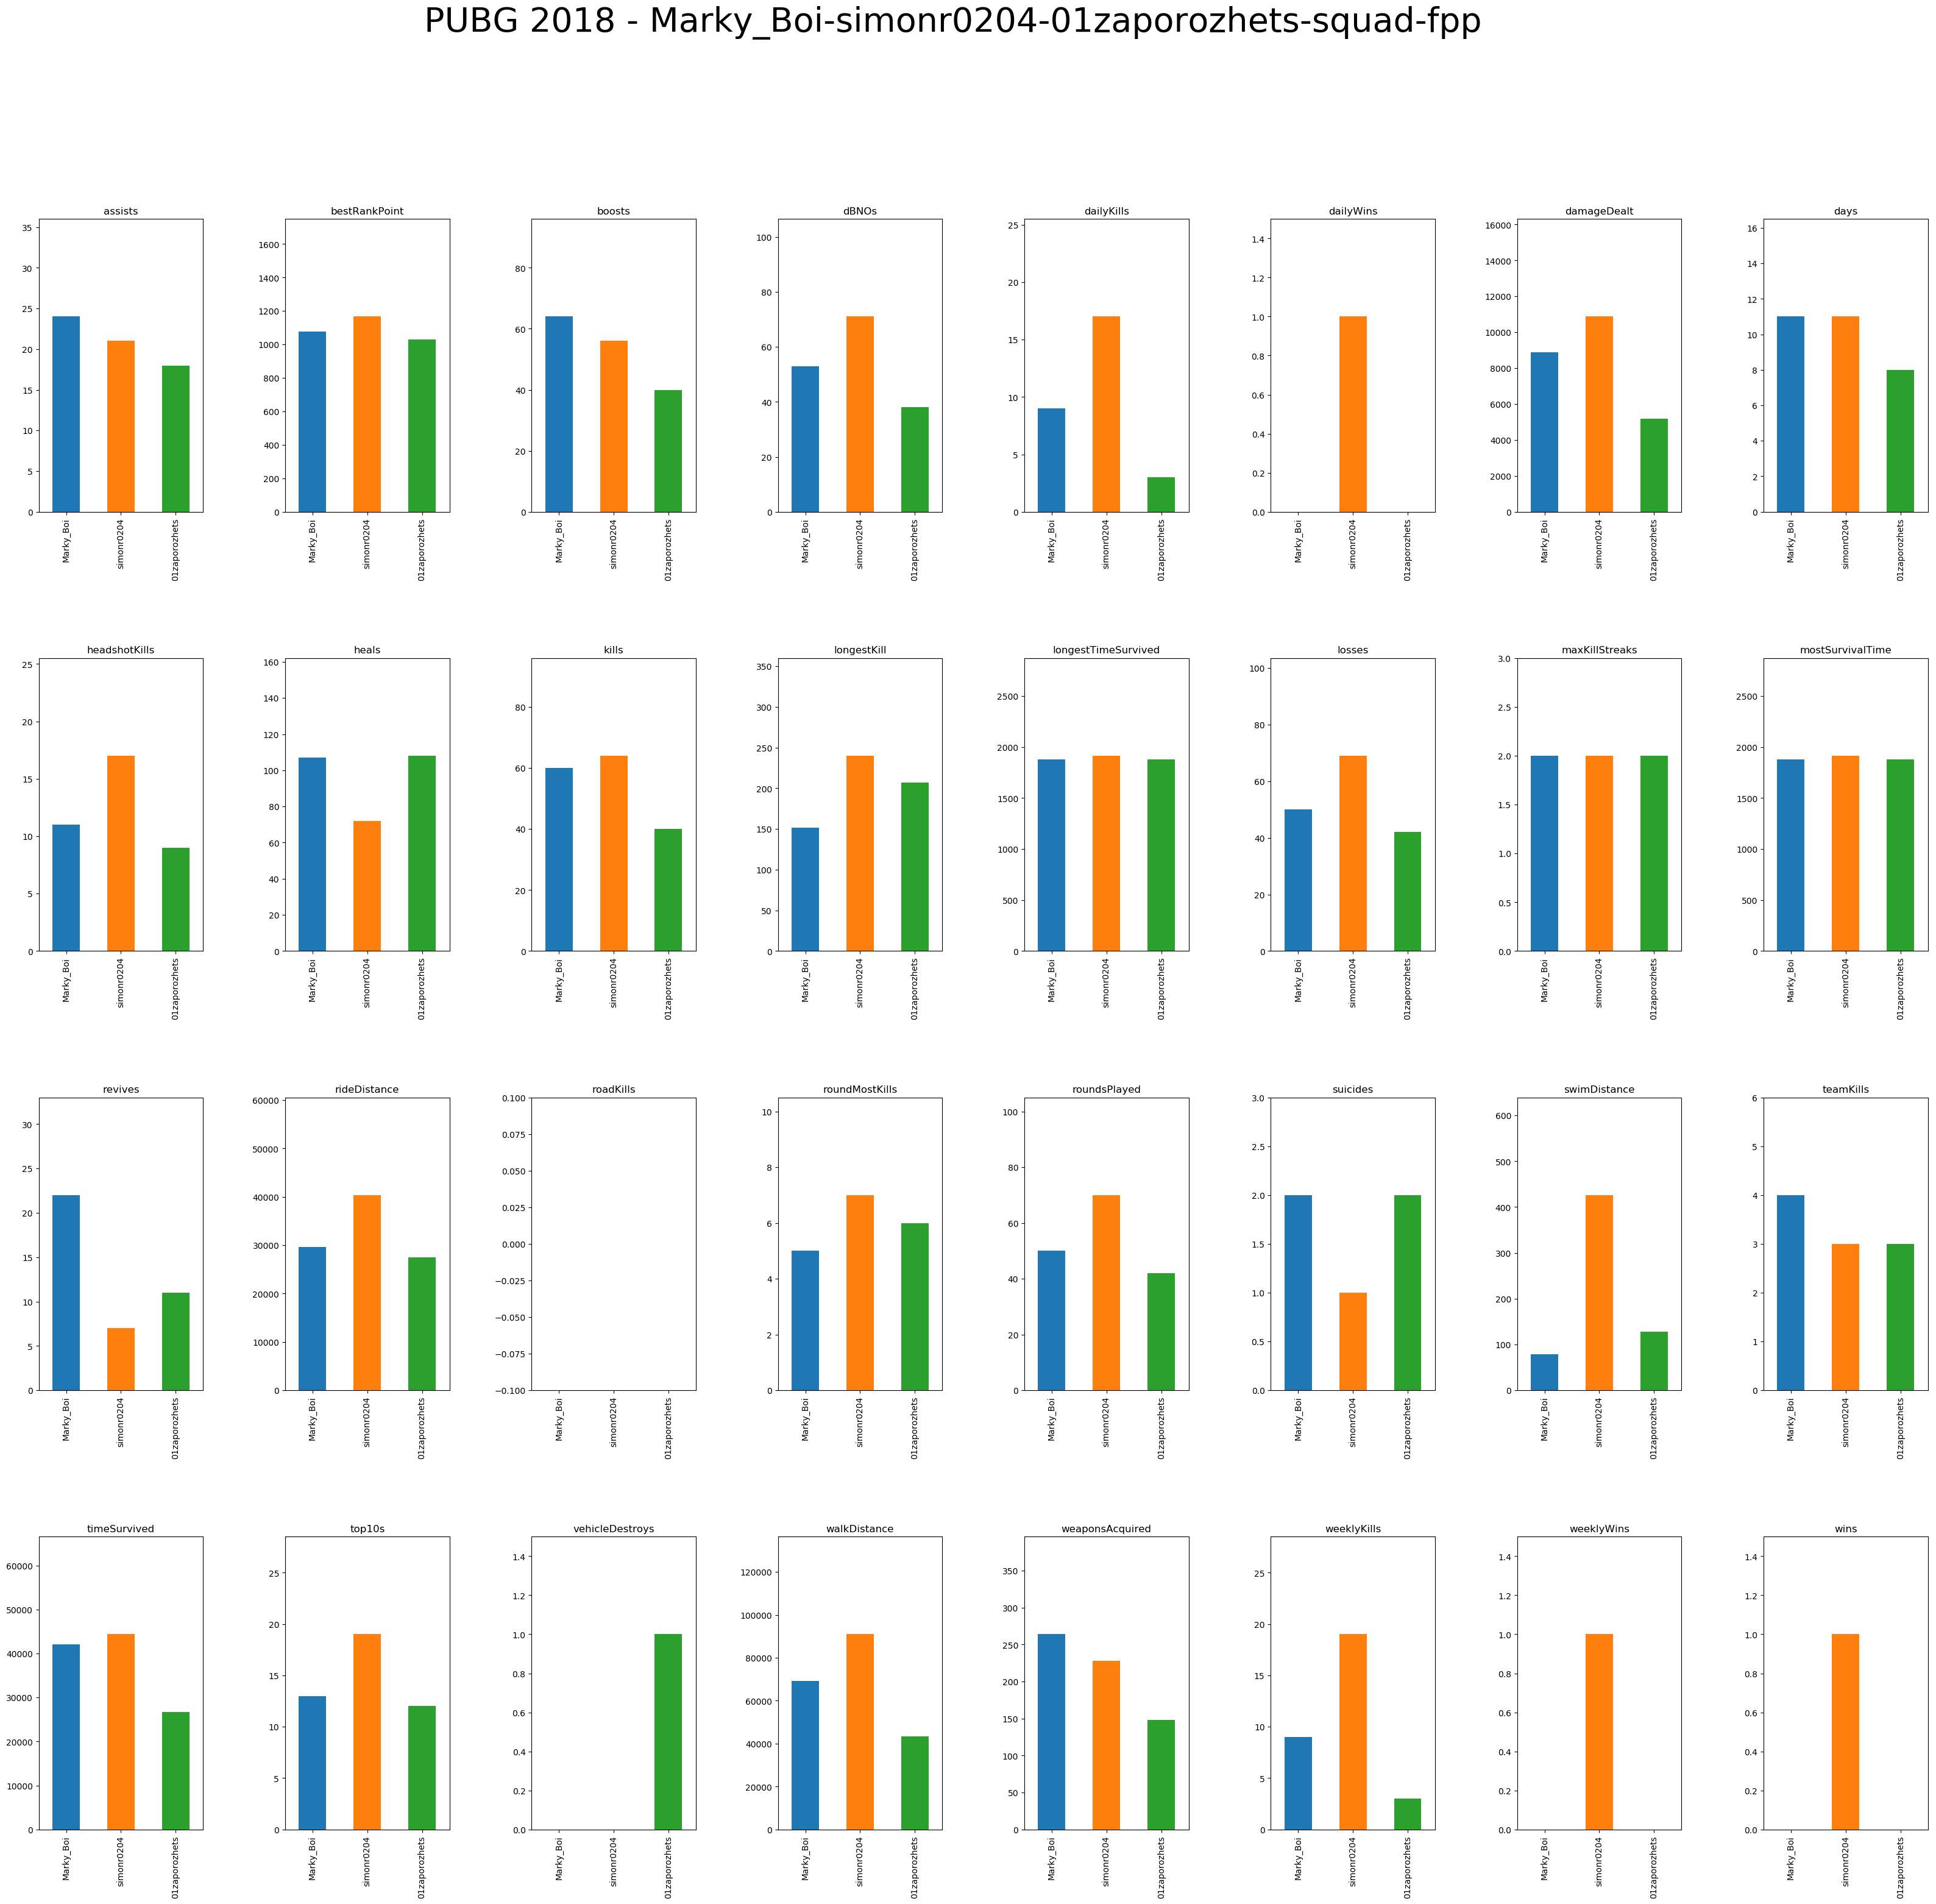

In [11]:
players = ['Marky_Boi', 'simonr0204', '01zaporozhets']      #Players to compare         
plot_modes = ['solo-fpp', 'duo-fpp' , 'squad-fpp']                 #Modes to draw plots for (one file per mode. Option are: solo/duo/squad  - fpp/tpp)
drop_graphs = ['rankPointsTitle','rankPoints','killPoints','winPoints']  #Attributes not to include in figures


compare(players, plot_modes, drop_graphs)  #Graphs saved to new folder